In [ ]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np

import torch
import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt
from tqdm import trange

DEVICE = 'cuda'

torch.__version__, torch.cuda.is_available()

In [32]:
class RNNCell(nn.Module):
    def __init__(self, in_size, out_size):
        super(RNNCell, self).__init__()
        self.h = nn.Linear(in_size + out_size, out_size)
        self.u = nn.Linear(in_size + out_size, out_size)

    def forward(self, x, h):
        cat = torch.cat((x, h), dim=-1)

        new = torch.tanh(self.h(cat))
        u = torch.sigmoid(self.u(cat))
        out = u * h + (1 - u) * new

        return out, out

In [33]:
cell = RNNCell(10, 20)
# cell = torch.jit.script(cell)

x = torch.rand(5, 10)
h = torch.rand(5, 20)

y, h = cell(x, h)
y.shape, h.shape, x.shape

(torch.Size([5, 20]), torch.Size([5, 20]), torch.Size([5, 10]))

In [34]:
class RNNLoop(nn.Module):
    def __init__(self, in_size, out_size):
        super(RNNLoop, self).__init__()
        self.in_size = in_size
        self.out_size = out_size

        self.cell = RNNCell(in_size, out_size)
#         self.cell = torch.jit.script(self.cell)

        self.DEVICE = DEVICE
        
    def forward(self, xs):
        bs = xs.size(0)
        seq_size = xs.size(1)

        h = torch.zeros(bs, self.out_size).to(self.DEVICE)
        y = torch.zeros(bs, self.out_size).to(self.DEVICE)
        rollout = torch.zeros(bs, seq_size, self.out_size).to(self.DEVICE)

        for i in range(xs.size(0)):
            y, h = self.cell(xs[:, i], h)
            rollout[:, i] = y

        return rollout

In [35]:
def RNN(in_size, out_size):
    loop = RNNLoop(in_size, out_size)
#     loop = torch.jit.script(loop)
    return loop.to(DEVICE)

In [36]:
rnn = RNN(10, 20)
# print(rnn.code)

xs = torch.rand(2, 12, 10).to(DEVICE)
rnn(xs).shape

torch.Size([2, 12, 20])

(torch.Size([28, 28]), torch.Size([28, 28]))

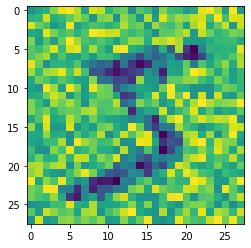

In [37]:
# Trining set
dataset = torchvision.datasets.MNIST(root='./data', download=True)
data = np.array(dataset[0][0]) / 255

X, y = torch.rand(28, 28).to(DEVICE), \
       torch.Tensor(data).to(DEVICE)

next_batch = lambda: (X.reshape(1, 28, 28), y.reshape(1, 28, 28))

plt.imshow(X.cpu().numpy() - y.cpu().numpy())
X.shape, y.shape

In [38]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, input):
        return self.lambd(input)

In [39]:
model = nn.Sequential(
    LambdaLayer(lambda x: x.reshape(1, -1, 1)),
    nn.GRU(1, 128, num_layers=2, batch_first=True),
    LambdaLayer(lambda x: x[0]),
    nn.Linear(128, 1),
    nn.Sigmoid(),
).to(DEVICE)

train = nn.Sequential(
    model,
    LambdaLayer(lambda x: x.reshape(1, 28, 28)),
)

predict = nn.Sequential(
    model,
    LambdaLayer(lambda x: x.reshape(28, 28)),
    LambdaLayer(lambda x: x.cpu().detach().numpy()),
)

sum(
    torch.prod(torch.Tensor(list((p.size()))))
    for p in model.parameters()
).item()

149505.0

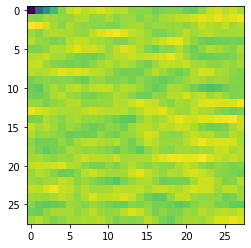

In [40]:
plt.imshow(predict(X.reshape(1, 28, 28)))

In [41]:
def fit(epochs, model, next_batch):
    history = []
    criterion = torch.nn.BCELoss().to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

    t = trange(epochs)
    for i in t:
        optimizer.zero_grad()

        X, y = next_batch()
        logits = model(X)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()
        l = loss.item()

        history.append(l)
        t.set_description('Loss: %.8f' % l)
        t.refresh()

    return history

In [42]:
history = fit(100, model=train, next_batch=next_batch)

Loss: 0.39943379: 100%|██████████| 1000/1000 [01:43<00:00,  9.70it/s]


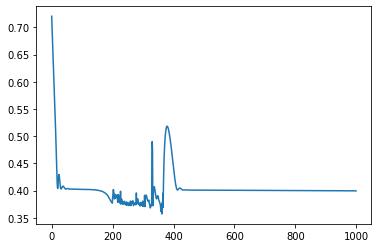

In [43]:
plt.plot(history)

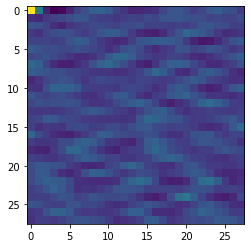

In [44]:
o = predict(X)
plt.imshow(o)

In [45]:
model = nn.Sequential(
    LambdaLayer(lambda x: x.reshape(1, -1, 1)),
    RNN(1, 128),
    nn.Linear(128, 1),
    nn.Sigmoid(),
).to(DEVICE)

train = nn.Sequential(
    model,
    LambdaLayer(lambda x: x.reshape(1, 28, 28)),
)

predict = nn.Sequential(
    model,
    LambdaLayer(lambda x: x.reshape(28, 28)),
    LambdaLayer(lambda x: x.cpu().detach().numpy()),
)

sum(
    torch.prod(torch.Tensor(list((p.size()))))
    for p in model.parameters()
).item()

33409.0

In [ ]:
history = fit(10000, model=train, next_batch=next_batch)

Loss: 0.40054056:  11%|█         | 1062/10000 [00:04<00:33, 269.10it/s]

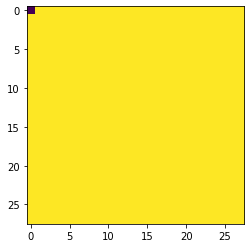

In [47]:
o = predict(X)
plt.imshow(o)